## Path Planning using RL with PPO algortithm

This notebook was divide in tow part, the firt one corresponde to get the map from a real picture, where the obstacles was painted with red color.

The second part corresponds to the algorithm. This step we subdivided in two steps more, were we defined the model and the algorithm, and the next step corresponds tho the training method.

# Just run the notebook :)

In [1]:
%matplotlib inline
import cv2
import matplotlib
from matplotlib import colors
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import os
import skimage.io
import PIL.Image

## Getting the map in binary format

In [2]:
def show(image):
    # Figure size in inches
    plt.figure(figsize=(15, 15))
    
    # Show image, with nearest neighbour interpolation
    plt.imshow(image, interpolation='nearest')
    
def overlay_mask(mask, image):
    rgb_mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    img = cv2.addWeighted(rgb_mask, 0.5, image, 0.5, 0)
    show(img)
    
def convex_cnt(image):
    image = image.copy()
    _,contours, _ = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours_ = [cv2.cv2.convexHull(cnt) for cnt in contours ]
    mask = np.zeros(image.shape, np.uint8)
    [cv2.drawContours(mask, [cnt_], -1, 255, -1) for cnt_ in contours_] 
    return contours_,mask

def dilate_img(image_bin):
    img = image_bin.copy()
    kernel1 = np.ones((7,7),np.uint8)
    image_dilation = cv2.dilate(img,kernel,iterations = 1)
    return image_dilation
    

In [3]:
image = skimage.io.imread('pi_map2.jpg')
image = cv2.resize(image, None, fx=1/3, fy=1/3)
print("Dimensiones de la imagen= ", image.shape)
#PIL.Image.fromarray(image)

Dimensiones de la imagen=  (853, 640, 3)


In [4]:
# Blur image slightly
image_blur = cv2.GaussianBlur(image, (7, 7), 0)
#show(image_blur)

In [5]:
# Get contours from the image_blur
image_blur_hsv = cv2.cvtColor(image_blur, cv2.COLOR_RGB2HSV)

# 0-20 hue
min_ = np.array([0, 100, 75])
max_ = np.array([20, 230, 230])
image_bin1 = cv2.inRange(image_blur_hsv, min_, max_)

# 160-180 hue
min_ = np.array([160, 100, 100])
max_ = np.array([180, 230, 230])
image_bin2 = cv2.inRange(image_blur_hsv, min_, max_)

image_bin = image_bin2+image_bin1
#show_mask(image_bin)

In [6]:
# Clean up
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20, 20))

# Fill small gaps
image_bin_closed = cv2.morphologyEx(image_bin, cv2.MORPH_CLOSE, kernel)
#show_mask(image_bin_closed)

# Remove specks
image_bin_closed_then_opened = cv2.morphologyEx(image_bin_closed, cv2.MORPH_OPEN, kernel)
#show_mask(image_bin_closed_then_opened)

# Dilate the mask
image_dilation = dilate_img(image_bin_closed_then_opened)
#show_mask(image_dilation)

In [7]:
# Convexificando figuras 
contours, mask = convex_cnt(image_dilation)
#show_mask(mask)

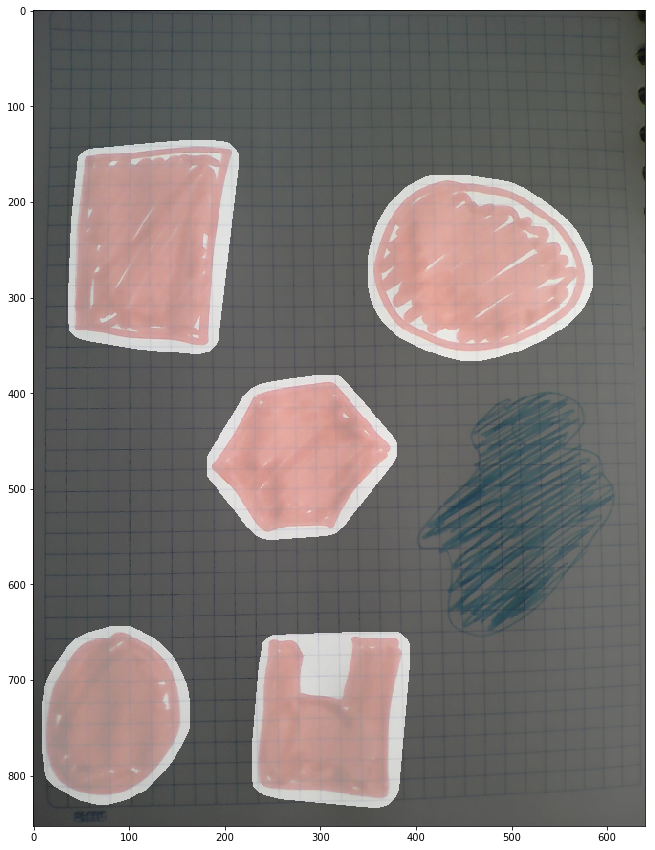

In [8]:
overlay_mask(mask, image)

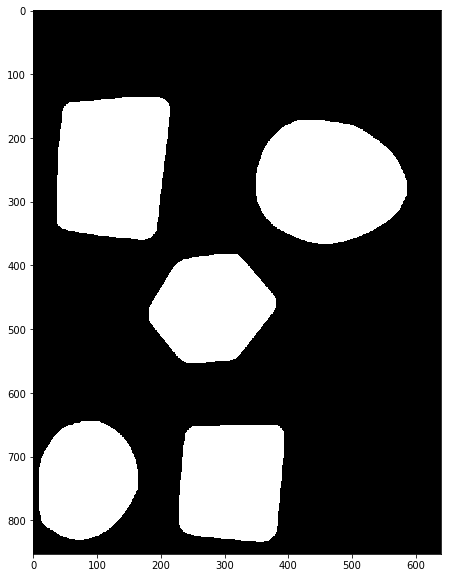

In [10]:
def show_mask(mask):
    plt.figure(figsize=(10, 10))
    plt.imshow(mask, cmap='gray')
show_mask(mask)

## Building the algorithm PPO using tensorflow
In this step, we configure the parameters for the model and the training method.
    
    LOAD = True ## True: no train and use previous pretrained model|| False: Train the model
    EP_MAX = 10000  # Number of iteration inside the enviorment
    EP_LEN = 800    # Max Number of step for every iteration
    GAMMA = 0.9     # Gamma for the discounter 
    A_LR = 0.0002   # Learning rate for the actor
    C_LR = 0.0002   # Learning rate for the critic
    BATCH = 64      # Standar Number of batch inside every iteration 
    A_UPDATE_STEPS = 8   # Number of training iteration whith each mini batch for the actor 
    C_UPDATE_STEPS = 8   # Number of training iteration whith each mini batch for the critic 

In [11]:
"""
A simple version of Proximal Policy Optimization (PPO) using single thread.
Based on:
1. Emergence of Locomotion Behaviours in Rich Environments (Google Deepmind): [https://arxiv.org/abs/1707.02286]
2. Proximal Policy Optimization Algorithms (OpenAI): [https://arxiv.org/abs/1707.06347]

"""
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import time
import random
from robot_env import CarDCENV
run_time=round(time.time())
LOAD = True ## True: no train and use previous pretrained model|| False: Train the model
EP_MAX = 10000
EP_LEN = 800
GAMMA = 0.9
A_LR = 0.0002
C_LR = 0.0002
BATCH = 64
A_UPDATE_STEPS = 8
C_UPDATE_STEPS = 8
#DISCRETE_ACTION = False
List_goald = [(400,600,400,800), (50,150,400,600)]

start = [random.randint(50,600),random.randint(20,50)]
goald = [random.randint(400,600),random.randint(400,800)]
env = CarDCENV(map_bin=mask, goald=goald,start_point=start)
#env = CarEnv(discrete_action=DISCRETE_ACTION)
S_DIM, A_DIM = env.state_dim_, env.action_dim
ACTION_BOUND = env.action_bound
METHOD = dict(name='clip', epsilon=0.2)                # Clipped surrogate objective, find this is better
															# epsilon=0.2 is in the paper
np.random.seed(7)
class PPO(object):
    def __init__(self,sess,LOAD):
        self.sess = sess #tf.Session()
        self.tfs = tf.placeholder(tf.float32, [None, S_DIM], 'state')

        # CRITIC #######################################
        with tf.variable_scope('critic'):
            l0 =  tf.layers.batch_normalization(self.tfs)
            l1 = tf.layers.dense(l0, 200, tf.nn.relu, name='layer1-critic')
            l10 =  tf.layers.batch_normalization(l1)
            l2 = tf.layers.dense(l10, 100, tf.nn.relu, name='layer2-critic')
            l20 =  tf.layers.batch_normalization(l2)
            self.v = tf.layers.dense(l20, 1, name = 'V_layer')

            self.tfdc_r = tf.placeholder(tf.float32, [None, 1], 'discounted_r')
            self.advantage = self.tfdc_r - self.v
            self.closs = tf.reduce_mean(tf.square(self.advantage))
            self.ctrain_op = tf.train.AdamOptimizer(C_LR).minimize(self.closs) # insted SGD

        # ACTOR ########################################
        # Current policy
        pi, pi_params = self._build_anet('pi', trainable=True)
        with tf.variable_scope('sample_action'):
            self.sample_op = tf.squeeze(pi.sample(1), axis=0)       # choosing action

        # Hold policy
        oldpi, oldpi_params = self._build_anet('oldpi', trainable=False)
        with tf.variable_scope('update_oldpi'): # Intercambia los pesos de las capas de hold_pi by pi
            self.update_oldpi_op = [oldp.assign(p) for p, oldp in zip(pi_params, oldpi_params)]

        self.tfa = tf.placeholder(tf.float32, [None, A_DIM], 'action')
        self.tfadv = tf.placeholder(tf.float32, [None, 1], 'advantage')

        # PPO implementation, Loss function ############
        with tf.variable_scope('loss'):
            with tf.variable_scope('surrogate_pp'):
                # ratio = tf.exp(pi.log_prob(self.tfa) - oldpi.log_prob(self.tfa))
                # ratio = probability ratio
                ratio = pi.prob(self.tfa) / oldpi.prob(self.tfa)
                surr = ratio * self.tfadv

            self.aloss = -tf.reduce_mean(tf.minimum(
                surr,
                tf.clip_by_value(ratio, 1.-METHOD['epsilon'], 1.+METHOD['epsilon'])*self.tfadv))

        # Implementation the Training method ############## 
        with tf.variable_scope('atrain'):
            self.atrain_op = tf.train.AdamOptimizer(A_LR).minimize(self.aloss)
        
        # Save the model into a tensorboard file
        tf.summary.FileWriter("log2/", self.sess.graph)
        
        # Load the pre training model or just initialize a new training
        saver = tf.train.Saver()
        path = './car_save'
        if LOAD:
            saver.restore(sess, tf.train.latest_checkpoint(path))
        else:
            sess.run(tf.global_variables_initializer())


    def update(self, s, a, r):
        # Update old policy
        self.sess.run(self.update_oldpi_op)
        
        # Calculate advantage
        adv = self.sess.run(self.advantage, {self.tfs: s, self.tfdc_r: r})

        # update actor
        [self.sess.run(self.atrain_op, {self.tfs: s, self.tfa: a, self.tfadv: adv}) for _ in range(A_UPDATE_STEPS)]

        # update critic
        [self.sess.run(self.ctrain_op, {self.tfs: s, self.tfdc_r: r}) for _ in range(C_UPDATE_STEPS)]

    def _build_anet(self, name, trainable): # Build the current & hold structure for the policies 
        with tf.variable_scope(name):
            l0 =  tf.layers.batch_normalization(self.tfs)
            l1 = tf.layers.dense(l0, 200, tf.nn.relu, trainable=trainable)
            l10 =  tf.layers.batch_normalization(l1)
            l2 = tf.layers.dense(l10, 100, tf.nn.relu, trainable=trainable)
            l20 =  tf.layers.batch_normalization(l2)

            mu = tf.layers.dense(l20, A_DIM, tf.nn.tanh, trainable=trainable, name = 'mu_'+name)
            sigma= tf.layers.dense(l20, A_DIM, tf.nn.softplus, trainable=trainable,name ='sigma_'+name )
            norm_dist = tf.distributions.Normal(loc=mu, scale=sigma) # Loc is the mean
        params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=name) #Recolecta los pesos de los layers l1,mu/2,sigma
        return norm_dist, params

    def choose_action(self, s):
        s = s[np.newaxis, :]
        a = self.sess.run(self.sample_op, {self.tfs: s})[0]
        #self.sess.run(self.update_states)
        #print(a)
        return np.clip(a, *ACTION_BOUND) # limita la salida de valores entre -1 & 1, a cada uno de los valores de 'a'

    def get_v(self, s):
        if s.ndim < 2: s = s[np.newaxis, :]
        return self.sess.run(self.v, {self.tfs: s})[0, 0] # Salida de NN del Critic|| V = learned state-value function

/home/davelinux/.virtualenvs/dave/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Training method - Epochs and Episodes
In the same way like the paper PPO https://arxiv.org/pdf/1707.06347.pdf

In [12]:
sess = tf.Session()
ppo = PPO(sess,LOAD)
path = './car_save'
saver = tf.train.Saver()

def train(env):
    all_ep_r = []
    buffer_s, buffer_a, buffer_r,buffer_v_s_ = [], [], [],[]
    for ep in range(EP_MAX):
        goald_rand = random.choice(List_goald)
        env.goald = [random.randint(goald_rand[0],goald_rand[1]),random.randint(goald_rand[2],goald_rand[3])]
        env.start_point = [random.randint(50,600),random.randint(20,50)]
        s = env.reset()
        ep_r = 0
        ep_step=0
        for t in range(EP_LEN):    # in one episode
            #env.render()
            a = ppo.choose_action(s)
            s_, r, done,plus = env.step(a) # observation, reward, done, info|| 'a' steering
            #print(s_)
            #v_s_ = ppo.get_v(s_)
            buffer_s.append(s)
            buffer_a.append(a)
            buffer_r.append((r))    # El diseñador define la forma, [-1 1] 1 es lo mejor, -1 es lo mas bajo
            #buffer_v_s_.append(v_s_)
            #print(a)
            s = s_
            ep_r += r
            ep_step += 1
            
            # update ppo
            if (t+1) % BATCH == 0 or t == EP_LEN-1 or done or plus:
                #print(s_)
                v_s_ = ppo.get_v(s_) # Obteniendo la respuesta de la NN del Critic, entregando el estado 's_' 
                						# V = learned state-value function
                discounted_r = []
                #for r,v_s_ in zip (buffer_r[::-1],buffer_v_s_[::-1]): # [::-1] invierte el orden en el que toma los valores del buffer
                for r in buffer_r[::-1]: # [::-1]  
                    v_s_ = r + GAMMA * v_s_
                    discounted_r.append(v_s_)
                discounted_r.reverse()

                bs, ba, br = np.vstack(buffer_s), np.vstack(buffer_a), np.array(discounted_r)[:, np.newaxis]
                buffer_s, buffer_a, buffer_r,buffer_v_s_ = [], [], [],[]
                ppo.update(bs, ba, br) # Entrenar el Critico y el actor (Estado, acciones, discounted_r)
                print("aprende")
                if plus : print("Éxito Total") 
                elif done : print("colision") 

            if done or t == EP_LEN - 1:
                print('Ep:', ep,'| reward: ',ep_r,'| Steps: %i' % int(ep_step))
                break
        
        if ep == 0: all_ep_r.append(ep_r)
        else: all_ep_r.append(all_ep_r[-1]*0.9 + ep_r*0.1)
        print("Ep: %i" % ep, "|Ep_r: %i" % ep_r, 
              "PPO: Method="+METHOD['name'] + " epsilon:"+ str(METHOD['epsilon']) )
            
    name_file = 'auto_car_'+'final'+'_'+str(run_time)+'.ckpt'
    ckpt_path = os.path.join(path, name_file)
    save_path = saver.save(sess, ckpt_path, write_meta_graph=False)
    print("\nSave Model FINAL %s\n" % save_path)

    plt.plot(np.arange(len(all_ep_r)), all_ep_r)
    plt.xlabel('Episode');plt.ylabel('Moving averaged episode reward');plt.show()

def eval(env):
    n=0
    while n<10:
        goald_rand = random.choice(List_goald)
        env.goald = [random.randint(400,600),random.randint(400,800)]#[random.randint(400,600),random.randint(50,100)]
        env.start_point =[random.randint(50,600),random.randint(20,50)]#[random.randint(100,600),random.randint(750,800)]
        s = env.reset()
        while True:
            #env.render()
            a = ppo.choose_action(s)
            s_, r, done,_ = env.step(a)
            s = s_
            mp = env.render()
            cv2.imshow('Mapa', mp)
            if (cv2.waitKey(1) & 0x77 == ord('q')) or done:
                cv2.destroyAllWindows()
                break
        n = n+1

INFO:tensorflow:Restoring parameters from ./car_save/auto_car_final_1544563909.ckpt


## Run the Code

In [13]:
if __name__ == '__main__':
    if LOAD:
        eval(env)
    else:
        try:
            train(env)
        except KeyboardInterrupt:
            time.sleep(2)
            name_file = 'auto_car_'+'final'+'_'+str(run_time)+'.ckpt'
            ckpt_path = os.path.join(path, name_file)
            save_path = saver.save(sess, ckpt_path, write_meta_graph=False)
            print("\nSave Model FINAL %s\n" % save_path)